<a href="https://colab.research.google.com/github/channiech609/Gen-AI/blob/main/notebooks/ThirdRun_100epoch_20kInput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup & Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Settings
nz = 100       # Latent vector size
ngf = 64       # Generator feature maps
ndf = 64       # Discriminator feature maps
nc = 1         # Number of channels (grayscale)
image_size = 64
batch_size = 128
num_epochs = 100
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
GPU device name: Tesla T4


**Data Pipeline**

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full dataset first
full_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

subset_size = 20000  # Training on 1024
subset_indices = list(range(subset_size))
dataset = torch.utils.data.Subset(full_dataset, subset_indices)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

**Generator & Discriminator Definitions**

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

**GAN Training Class**

In [ ]:
class GAN:
    def __init__(self, netG, netD, device, latent_dim=100, lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0):
        self.device = device
        self.netG = netG.to(device)
        self.netD = netD.to(device)
        self.latent_dim = latent_dim
        self.criterion = nn.BCELoss()
        self.optG = optim.Adam(netG.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optD = optim.Adam(netD.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.fixed_noise = torch.randn(64, latent_dim, device=device)
        self.history = {"G_losses": [], "D_losses": [], "images": []}

    def train(self, dataloader, num_epochs=50, log_interval=100):
        print("Starting Training Loop...")
        for epoch in range(1, num_epochs + 1):
            for i, (real_imgs, _) in enumerate(dataloader, 1):
                b_size = real_imgs.size(0)
                real_imgs = real_imgs.to(self.device)

                # --- Train Discriminator ---
                self.netD.zero_grad()
                label = torch.full((b_size,), 1.0, device=self.device)
                output = self.netD(real_imgs).view(-1)
                errD_real = self.criterion(output, label)
                errD_real.backward()
                D_x = output.mean().item()

                noise = torch.randn(b_size, self.latent_dim, device=self.device)
                fake_imgs = self.netG(noise)
                label.fill_(0.0)
                output = self.netD(fake_imgs.detach()).view(-1)
                errD_fake = self.criterion(output, label)
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                errD = errD_real + errD_fake
                self.optD.step()

                # --- Train Generator ---
                self.netG.zero_grad()
                label.fill_(1.0)
                output = self.netD(fake_imgs).view(-1)
                errG = self.criterion(output, label)
                errG.backward()
                D_G_z2 = output.mean().item()
                self.optG.step()

                self.history["D_losses"].append(errD.item())
                self.history["G_losses"].append(errG.item())

                print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                      f"Loss_D: {errD:.4f} Loss_G: {errG:.4f} "
                      f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

            # Save sample grid
            with torch.no_grad():
                fake = self.netG(self.fixed_noise).cpu()
                grid = vutils.make_grid(fake, padding=2, normalize=True)
                self.history["images"].append(grid)

        print("Training Complete.")
        return self.history

**Baseline (No Regularization)**

In [6]:
netG_base = Generator(nz, ngf, nc)
netD_base = Discriminator(nc, ndf)
gan_base = GAN(netG_base, netD_base, device)
history_base = gan_base.train(dataloader, num_epochs)

Streaming output truncated to the last 5000 lines.
[69/100][26/157] Loss_D: 0.0209 Loss_G: 5.0244 D(x): 0.9908 D(G(z)): 0.0113/0.0126
[69/100][27/157] Loss_D: 0.0268 Loss_G: 5.6779 D(x): 0.9970 D(G(z)): 0.0221/0.0064
[69/100][28/157] Loss_D: 0.0175 Loss_G: 5.8063 D(x): 0.9914 D(G(z)): 0.0086/0.0053
[69/100][29/157] Loss_D: 0.0201 Loss_G: 5.8047 D(x): 0.9846 D(G(z)): 0.0043/0.0055
[69/100][30/157] Loss_D: 0.0155 Loss_G: 5.4060 D(x): 0.9915 D(G(z)): 0.0068/0.0082
[69/100][31/157] Loss_D: 0.0215 Loss_G: 5.1841 D(x): 0.9908 D(G(z)): 0.0120/0.0107
[69/100][32/157] Loss_D: 0.0260 Loss_G: 5.2055 D(x): 0.9909 D(G(z)): 0.0164/0.0088
[69/100][33/157] Loss_D: 0.0289 Loss_G: 5.0388 D(x): 0.9834 D(G(z)): 0.0118/0.0101
[69/100][34/157] Loss_D: 0.0160 Loss_G: 5.5355 D(x): 0.9934 D(G(z)): 0.0092/0.0076
[69/100][35/157] Loss_D: 0.0278 Loss_G: 4.9354 D(x): 0.9862 D(G(z)): 0.0134/0.0112
[69/100][36/157] Loss_D: 0.0186 Loss_G: 5.5455 D(x): 0.9961 D(G(z)): 0.0144/0.0065
[69/100][37/157] Loss_D: 0.0248 Loss

**L2 Regularization**

In [7]:
netG_l2 = Generator(nz, ngf, nc)
netD_l2 = Discriminator(nc, ndf)
gan_l2 = GAN(netG_l2, netD_l2, device, weight_decay=0.01)
history_l2 = gan_l2.train(dataloader, num_epochs)

Streaming output truncated to the last 5000 lines.
[69/100][26/157] Loss_D: 0.2075 Loss_G: 5.8116 D(x): 0.8710 D(G(z)): 0.0234/0.0101
[69/100][27/157] Loss_D: 0.0731 Loss_G: 4.8212 D(x): 0.9639 D(G(z)): 0.0327/0.0176
[69/100][28/157] Loss_D: 0.1519 Loss_G: 6.1251 D(x): 0.9856 D(G(z)): 0.1213/0.0041
[69/100][29/157] Loss_D: 0.0916 Loss_G: 5.3530 D(x): 0.9323 D(G(z)): 0.0175/0.0072
[69/100][30/157] Loss_D: 0.2094 Loss_G: 3.5523 D(x): 0.8819 D(G(z)): 0.0607/0.0463
[69/100][31/157] Loss_D: 0.2300 Loss_G: 6.8673 D(x): 0.9779 D(G(z)): 0.1742/0.0019
[69/100][32/157] Loss_D: 0.1540 Loss_G: 5.5907 D(x): 0.8833 D(G(z)): 0.0096/0.0063
[69/100][33/157] Loss_D: 0.1046 Loss_G: 3.9409 D(x): 0.9269 D(G(z)): 0.0234/0.0341
[69/100][34/157] Loss_D: 0.2458 Loss_G: 7.5232 D(x): 0.9844 D(G(z)): 0.1898/0.0011
[69/100][35/157] Loss_D: 0.3737 Loss_G: 4.0504 D(x): 0.7388 D(G(z)): 0.0027/0.0420
[69/100][36/157] Loss_D: 0.1681 Loss_G: 5.2089 D(x): 0.9960 D(G(z)): 0.1319/0.0113
[69/100][37/157] Loss_D: 0.0635 Loss

**Dropout in Discriminator**

In [8]:
class DiscriminatorDropout(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netG_dropout = Generator(nz, ngf, nc)
netD_dropout = DiscriminatorDropout(nc, ndf)
gan_dropout = GAN(netG_dropout, netD_dropout, device)
history_dropout = gan_dropout.train(dataloader, num_epochs)

Streaming output truncated to the last 5000 lines.
[69/100][26/157] Loss_D: 0.3039 Loss_G: 1.1851 D(x): 0.7769 D(G(z)): 0.0065/0.4110
[69/100][27/157] Loss_D: 0.9447 Loss_G: 11.3047 D(x): 0.9984 D(G(z)): 0.5095/0.0000
[69/100][28/157] Loss_D: 2.5534 Loss_G: 0.5796 D(x): 0.1766 D(G(z)): 0.0001/0.6859
[69/100][29/157] Loss_D: 1.6800 Loss_G: 13.1717 D(x): 0.9997 D(G(z)): 0.7067/0.0000
[69/100][30/157] Loss_D: 5.8968 Loss_G: 0.1587 D(x): 0.0184 D(G(z)): 0.0001/0.8715
[69/100][31/157] Loss_D: 4.0744 Loss_G: 10.3927 D(x): 1.0000 D(G(z)): 0.9439/0.0005
[69/100][32/157] Loss_D: 1.1975 Loss_G: 2.5514 D(x): 0.4497 D(G(z)): 0.0182/0.2026
[69/100][33/157] Loss_D: 0.9324 Loss_G: 6.6119 D(x): 0.9938 D(G(z)): 0.4381/0.0079
[69/100][34/157] Loss_D: 0.3442 Loss_G: 4.4537 D(x): 0.7961 D(G(z)): 0.0352/0.0391
[69/100][35/157] Loss_D: 0.6402 Loss_G: 1.0867 D(x): 0.7036 D(G(z)): 0.1442/0.4707
[69/100][36/157] Loss_D: 1.0216 Loss_G: 8.3422 D(x): 0.9925 D(G(z)): 0.5130/0.0010
[69/100][37/157] Loss_D: 1.2742 L

**BatchNorm Off (in Discriminator)**

In [9]:
class DiscriminatorNoBN(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netG_bn = Generator(nz, ngf, nc)
netD_bn = DiscriminatorNoBN(nc, ndf)
gan_bn = GAN(netG_bn, netD_bn, device)
history_bn = gan_bn.train(dataloader, num_epochs)

Streaming output truncated to the last 5000 lines.
[69/100][26/157] Loss_D: 0.1950 Loss_G: 4.6731 D(x): 0.9951 D(G(z)): 0.1662/0.0410
[69/100][27/157] Loss_D: 0.1644 Loss_G: 3.1941 D(x): 0.9383 D(G(z)): 0.0437/0.0851
[69/100][28/157] Loss_D: 0.1567 Loss_G: 3.6426 D(x): 0.9922 D(G(z)): 0.1211/0.0641
[69/100][29/157] Loss_D: 0.1114 Loss_G: 5.4210 D(x): 0.9962 D(G(z)): 0.0924/0.0170
[69/100][30/157] Loss_D: 0.1744 Loss_G: 2.5195 D(x): 0.9224 D(G(z)): 0.0054/0.1176
[69/100][31/157] Loss_D: 0.6302 Loss_G: 5.0720 D(x): 0.9996 D(G(z)): 0.4265/0.0260
[69/100][32/157] Loss_D: 0.2002 Loss_G: 3.8100 D(x): 0.9257 D(G(z)): 0.0300/0.0536
[69/100][33/157] Loss_D: 0.1686 Loss_G: 3.8090 D(x): 0.9949 D(G(z)): 0.1446/0.0470
[69/100][34/157] Loss_D: 0.0311 Loss_G: 5.5867 D(x): 0.9921 D(G(z)): 0.0213/0.0103
[69/100][35/157] Loss_D: 0.0407 Loss_G: 6.0934 D(x): 0.9719 D(G(z)): 0.0025/0.0060
[69/100][36/157] Loss_D: 0.0567 Loss_G: 4.5226 D(x): 0.9922 D(G(z)): 0.0397/0.0357
[69/100][37/157] Loss_D: 0.1674 Loss

**Evaluation – Loss Plots & Image Comparison**

Loss Plots

In [ ]:
def plot_losses(histories, labels):
    plt.figure(figsize=(12, 5))
    for h, label in zip(histories, labels):
        plt.plot(h['G_losses'], label=f'{label} - G')
        plt.plot(h['D_losses'], label=f'{label} - D')
    plt.title("Generator and Discriminator Losses")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)


def plot_generator_losses(histories, labels):
    plt.figure(figsize=(12, 5))
    for h, label in zip(histories, labels):
        plt.plot(h['G_losses'], label=f'{label} - G')
    plt.title("Generator Losses")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_generator_losses(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)


Generated Image Comparison

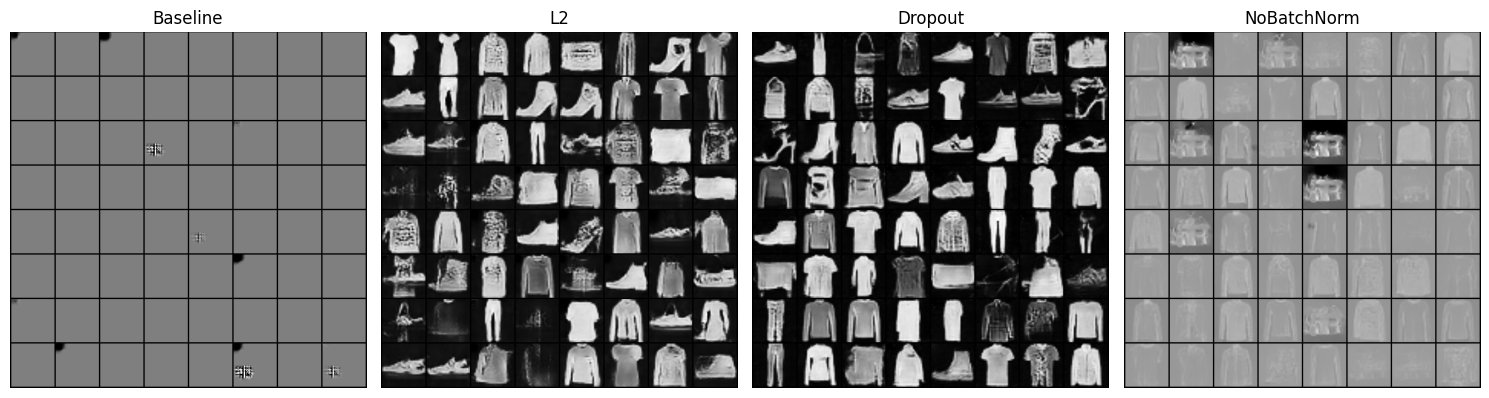

In [11]:
def show_generated_images(histories, labels, epoch=-1):
    fig, axs = plt.subplots(1, len(histories), figsize=(15, 5))
    for i, (h, label) in enumerate(zip(histories, labels)):
        img = h["images"][epoch]
        axs[i].imshow(img.permute(1, 2, 0).numpy())
        axs[i].set_title(label)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

show_generated_images(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)

FID

In [ ]:
!pip install torch-fidelity
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
os.kill(os.getpid(), 9)  # Force restarts runtime

In [12]:
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T
import torch.nn.functional as F

# --- Helpers ---
denorm = T.Normalize((-1,), (2,))
def prep_images(imgs):
    # denormalize → [0,1], resize to 299×299, repeat channels
    imgs = denorm(imgs).clamp(0, 1)
    imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
    return imgs.repeat(1, 3, 1, 1)

# Collect one batch of 128 real images (to CPU/GPU)
real_list = []
count = 0
for imgs, _ in dataloader:
    real_list.append(imgs)
    count += imgs.size(0)
    if count >= 128:
        break
real_imgs = torch.cat(real_list, dim=0)[:128].to(device)
real_imgs = prep_images(real_imgs)

# --- FID computation ---
def compute_fid(models_dict, num_samples=128, step=32):
    fid_scores = {}
    for label, netG in models_dict.items():
        fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
        fid.update(real_imgs, real=True)

        netG.eval()
        seen = 0
        with torch.no_grad():
            while seen < num_samples:
                b = min(step, num_samples - seen)
                noise = torch.randn(b, nz, device=device)
                fake = netG(noise)
                fake = prep_images(fake)
                fid.update(fake, real=False)
                seen += b

        score = fid.compute().item()
        fid_scores[label] = round(score, 2)

    return fid_scores

# --- Run it for Dropout and NoBatchNorm ---
models_to_eval = {
    "Baseline":     netG_base,
    "L2":           netG_l2,
    "Dropout":      netG_dropout,
    "NoBatchNorm":  netG_bn
}

fid_results = compute_fid(models_to_eval)
print("FID Scores:", fid_results)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 196MB/s]


FID Scores: {'Baseline': 438.09, 'L2': 160.01, 'Dropout': 153.29, 'NoBatchNorm': 208.85}
